In [13]:
import os
import sys
sys.path.append('../../kl_tools/')
import numpy as np
import astropy.units as u
from astropy.units import Unit
import astropy.constants as const
from astropy.io import fits
import synphot
from synphot import Observation, SourceSpectrum
import stsynphot as stsyn
#print(stsyn.config.rootdir)
from specutils import Spectrum1D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim as gs
import galsim.roman as roman
from galsim.angle import Angle, radians
from astropy.visualization import ZScaleInterval, ImageNormalize
import yaml

import basis
import cube
import intensity
import likelihood
import mcmc
import parameters
from parameters import Pars
import priors
import utils
import velocity
from DataSimulator import DataSimulator
from likelihood import LogLikelihood_Roman, LogPosterior_Roman

# new modules
from spectrum import Spectrum
#from MockObs import Mock
#%matplotlib notebook
%matplotlib inline

# Roman Space Telescope

## Simulated Grism Observation

In [96]:
R = 461
z = 1
offset = -656.461*(1+z)*R/500
print(offset)
#wave_range = [656.3*(1+z)*(1-200/3e5), 656.3*(1+z)*(1+200/3e5)]

pars_total = {
    # priors of sampled parameters
    'priors':{
        'g1': priors.GaussPrior(0., 0.1),
        'g2': priors.GaussPrior(0., 0.1),
        'theta_int': priors.UniformPrior(-np.pi/2., np.pi/2.),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.GaussPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10),
        'rscale': priors.UniformPrior(0, 1),
    },
    # dimension parameters for model cube
    # Note that the dimensions and scales in this parameter are irrelevant
    # to the pixel scale and number of pixels in the observed image. The 
    # model cube object is by design independent of the configurations of
    # observations. A parametric surface brightness profile is drawn on 
    # this meta-grid, then observed data will be interpolated from that. 
    'model_dimension':{
        'Nx':32,
        'Ny':32,
        'scale':0.11,# arcsec
        'lambda_range': [1000., 1600.],
        'lambda_res': 1,# nm
        'lambda_unit': 'nm'
    },
    # intensity profile, or surface brightness model for the galaxy
    'intensity':{
        'type':'inclined_exp',
        'hlr':0.5,# arcsec
    },
    # kinematics model for the galaxy
    'velocity':{
        'model_name': 'default',
        'v_unit':Unit('km / s'),
        'r_unit':Unit('arcsec'),
    },
    # SED model for the galaxy
    'sed':{
        'template':'../../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 1.0,
        'wave_range': (500, 3000), # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': (400, 1.3e-18),
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines': {'Halpha': 5.0e-16, 'OII':[1e-15, 1.2e-15], 'OIII':[1e-15, 1.2e-15]},
        # intrinsic linewidth in nm
        'line_sigma_int': {'Halpha': 4, 'OII':[.2,.2], 'OIII':[.3,.3]},
    },
    # observation related parameters
    # Note that from the same galaxy and shear model, we can derive 
    # multiple types of data,
    # e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
    # Thus 'observations' is a list of dictionaries that specify 
    # observation-wise parameters.
    # TODO: maybe think about more flexible way to describe dispersion
    'observations': {
        'number_of_observations': 3,
        'obs_1': {# Roman WFI/GRISM observation, roll angle 1
            'inst_name':'Roman/WFI',
             'type':'grism',
             #'slit_width': 0.3,
             #'slit_offset': 0.0,
             'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
             'Nx': 256,# number of pixels
             'Ny': 32,
             'pixel_scale': 0.11,# arcsec
             'R_spec': R ,# at 1 micron
             # can be 'airy'/'moffat'/'kolmogorov'/'vonkarman'/'opticalpsf'
             'psf_type':'airy',
             # pass the needed params to build PSF model here
             # in case of airy, we don't need any params
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'disp_ang':0.,# radian
             'offset': offset,# pix
             'diameter':240,# cm
             'exp_time':1600.,# seconds
             'gain':1.,
             'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5,'apply_to_data':False}
         },
        'obs_2': {# Roman WFI/GRISM observation, roll angle 2
            'inst_name':'Roman/WFI',
             'type':'grism',
             #'slit_width': 0.3,
             #'slit_offset': 0.0,
             'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
             'Nx': 32,# number of pixels
             'Ny': 256,
             'pixel_scale': 0.11,# arcsec
             'R_spec': R, # at 1 micron
             'psf_type':'airy',
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'disp_ang':np.pi/2.,# radian
             'offset': offset,#pix
             'diameter':240,# cm
             'exp_time':1600.,# seconds
             'gain':1.,
             'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5,'apply_to_data':False}
         },
        'obs_3': {# Roman WFI/Photometry image observation, H band
            'inst_name':'Roman/WFI',
             'type':'photometry',
                 'bandpass':'../../data/Bandpass/Roman/WFI_F129.dat',
             'Nx': 32,# number of pixels
             'Ny': 32,
             'pixel_scale': 0.11,# arcsec
             'psf_type':'airy',
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'diameter':240,# cm
             'exp_time':600.,# seconds
             'gain':1.,
             'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5,'apply_to_data':False},
         },
    },
    
    'use_numba': False,
}
sp = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'rscale']
sp_val = [0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5]

test_Pars = Pars(sp, pars_total)

-1210.5140840000001


# Testing `DataSimulator` Class

In [97]:
ds = DataSimulator(test_Pars)
%time datavectors, covmats = ds.evaluateSimulatedData(sp_val)

Initializing DataSimulator...

[GrismGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 1600.00 seconds
--- Noise type = ccd
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
--- Theory slice dimension = (32, 32)
--- Theory slice scale = 0.11
--- Observed slice dimension = (32, 256)
--- Observed slice pixel scale = 0.11
--- Dispersion angle = 0.00 deg
--- Spectral resolution at 1um = 461.00
--- Grism offset = -1210.5140840000001 pixels

[GrismGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 1600.00 seconds
--- Noise type = ccd
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
--- Theory slice dimension = (32, 32)
--- Theory slice scale = 0.11
--- Observed slice dimension = (256, 32)
--- Obse

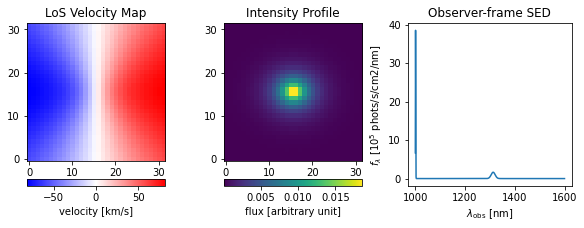

In [98]:
fig, axes = plt.subplots(1,3,figsize=(10,3))

cb1 = axes[0].imshow(ds.vmap_img*3e5, origin='lower', cmap='bwr')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("bottom", size="5%", pad=0.25)
plt.colorbar(cb1, cax=cax, orientation='horizontal', 
             label='velocity [km/s]')
axes[0].set_title('LoS Velocity Map')

cb2 = axes[1].imshow(ds.imap_img, origin='lower')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("bottom", size="5%", pad=0.25)
plt.colorbar(cb2, cax=cax, orientation='horizontal', label='flux [arbitrary unit]')
axes[1].set_title('Intensity Profile')

axes[2].plot(ds.lambda_cen, ds.sed.spectrum(ds.lambda_cen) * 1e5 )
axes[2].set(xscale='linear', yscale='linear',
            xlabel=r'$\lambda_\mathrm{obs}$ [nm]', ylabel=r'$f_\lambda$ [$10^{5}$ phots/s/cm2/nm]')
axes[2].set_title('Observer-frame SED')

plt.show()

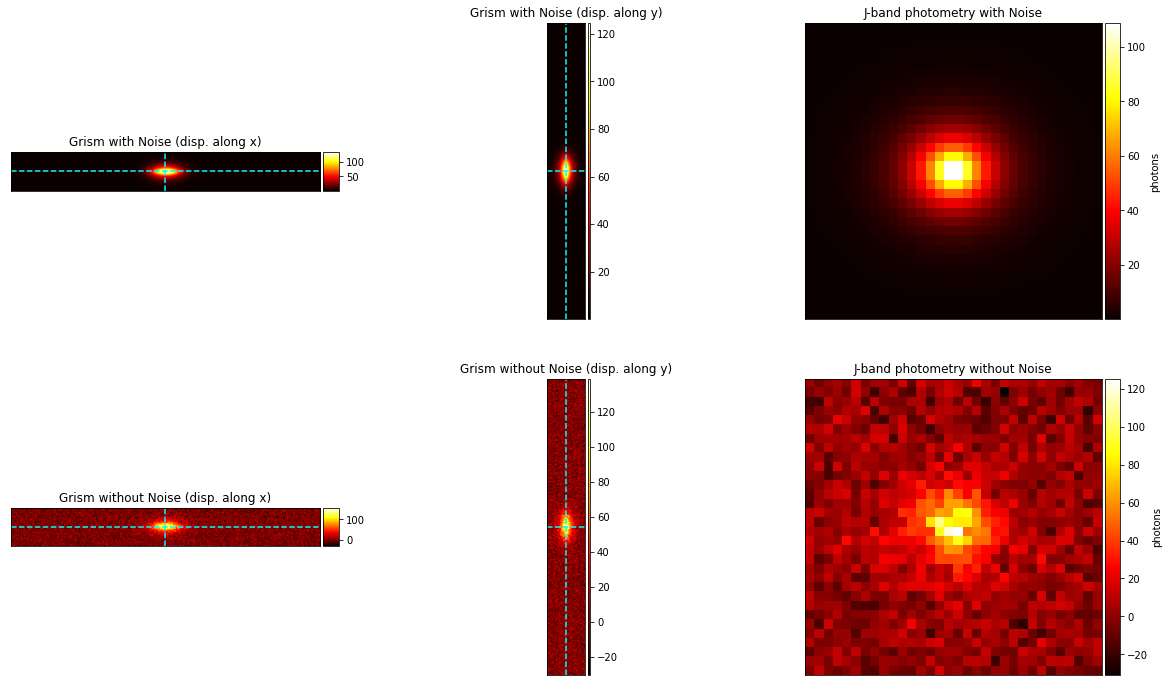

In [99]:
%matplotlib inline
fig, axes = plt.subplots(2,3, figsize=(20,12))
cmap = 'hot'

ax1 = axes[0,0]
_d = datavectors[0]-covmats[0]
cb1 = ax1.imshow(#np.arcsinh(_d),
                _d,
                 origin='lower', cmap=cmap,
                 #norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
xmid = np.mean(ax1.get_xlim())
ymid = np.mean(ax1.get_ylim())
ax1.axvline(xmid, color='cyan', ls='--')
ax1.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax1.set_title("Grism with Noise (disp. along x)")
plt.colorbar(cb1, cax=cax)#, label='photons')
ax1.set(xticks=[], yticks=[])

ax2 = axes[0,1]
_d = datavectors[1]-covmats[1]
cb2 = ax2.imshow(#np.arcsinh(_d),
                _d, 
                origin='lower', cmap=cmap,
                 #norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
xmid = np.mean(ax2.get_xlim())
ymid = np.mean(ax2.get_ylim())
ax2.axvline(xmid, color='cyan', ls='--')
ax2.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax2.set_title("Grism with Noise (disp. along y)")
plt.colorbar(cb2, cax=cax)#, label='photons')
ax2.set(xticks=[], yticks=[])

ax3 = axes[0,2]
_d = datavectors[2]-covmats[2]
cb3 = ax3.imshow(_d,
                 origin='lower', cmap=cmap, 
                #norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax3.set_title("J-band photometry with Noise")
plt.colorbar(cb3, cax=cax, label='photons')
ax3.set(xticks=[], yticks=[])

ax4 = axes[1,0]
_d = datavectors[0]
cb4 = ax4.imshow(_d, origin='lower', cmap=cmap,
                #norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
#ax4.imshow(ds.data_generators[0].slit_mask, origin='lower', cmap='binary', alpha=0.25)
xmid = np.mean(ax4.get_xlim())
ymid = np.mean(ax4.get_ylim())
ax4.axvline(xmid, color='cyan', ls='--')
ax4.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax4.set_title("Grism without Noise (disp. along x)")
plt.colorbar(cb4, cax=cax)#, label='photons')
ax4.set(xticks=[], yticks=[])

ax5 = axes[1,1]
_d = datavectors[1]
cb5 = ax5.imshow(_d, origin='lower', cmap=cmap,
                #norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
#ax5.imshow(ds.data_generators[1].slit_mask, origin='lower', cmap='binary', alpha=0.5)
xmid = np.mean(ax5.get_xlim())
ymid = np.mean(ax5.get_ylim())
ax5.axvline(xmid, color='cyan', ls='--')
ax5.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax5.set_title("Grism without Noise (disp. along y)")
plt.colorbar(cb5, cax=cax)#, label='photons')
ax5.set(xticks=[], yticks=[])

ax6 = axes[1,2]
_d = datavectors[2]
cb6 = ax6.imshow(_d, origin='lower', cmap=cmap, 
                #norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
divider = make_axes_locatable(ax6)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax6.set_title("J-band photometry without Noise")
plt.colorbar(cb6, cax=cax, label='photons')
ax6.set(xticks=[], yticks=[])

plt.show()


In [93]:
def PSNR(data, noise):
    res = []
    for d, n in zip(data, noise):
        mse = np.sum((d-n)**2) / (d.shape[0] * d.shape[1])
        psnr = 10 * np.log10(np.max(d)**2 / mse)
        res.append(psnr)
        n_mean, n_std = np.mean(n), np.std(n)
        print("max pix SNR: {:.3f}".format( (np.max(d)-n_mean)/n_std))
    return res
def ASNR(data, noise, detect_limit=3):
    res = []
    for d, n in zip(data, noise):
        noise_mean, noise_std = np.mean(n), np.std(n)
        mask = np.where(d > detect_limit*noise_std + noise_mean, 
                        np.ones(d.shape), np.zeros(d.shape) )
        S = np.sum( (d + n)  * mask )
        N = np.sqrt(np.sum(n*n*mask))
        snr = S/N
        res.append(snr)
    return res

In [94]:
psnr_dB = PSNR(datavectors, covmats)
asnr = ASNR(datavectors, covmats)
psnr_1 = [10.**(_psnr/10.) for _psnr in psnr_dB]

max pix SNR: 9.618
max pix SNR: 11.191
max pix SNR: 13.304


In [95]:
print(f'Peak SNR in dB = {psnr_dB}')
print(f'Peak SNR in 1 = {psnr_1}')
print(f'Aperture SNR = {asnr}')

Peak SNR in dB = [18.8659749800884, 20.761670942388474, 17.648449210275214]
Peak SNR in 1 = [77.01893304996612, 119.17004250275302, 58.189539598796614]
Aperture SNR = [75.8034282433415, 72.18763378520161, 38.32154263857935]


noise mean = -0.9175606966018677, noise std = 22.088523864746094
SNR = 668.8091279980075
noise mean = -0.602641224861145, noise std = 23.520925521850586
SNR = 666.6770836533889
noise mean = -0.14700797200202942, noise std = 10.321072578430176
SNR = 129.09858195913515


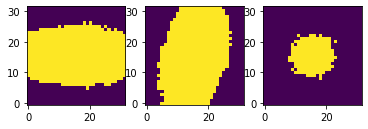

In [39]:
idx = 2
detect_lim = 5
include_noise = 1
fig, axes = plt.subplots(1,3)
for idx in range(3):
    data = datavectors[idx]
    noise = covmats[idx]
    noise_mean, noise_std = np.mean(noise), np.std(noise)
    print(f'noise mean = {noise_mean}, noise std = {noise_std}')
    mask = np.where(data > detect_lim*noise_std, np.ones(data.shape), np.zeros(data.shape))
    axes[idx].imshow(mask, origin='lower')

    S = np.sum( (data + noise * include_noise)  * mask)
    N = np.sqrt(np.sum(noise*noise*mask))
    snr = S/N
    print(f'SNR = {snr}')

<IPython.core.display.Javascript object>


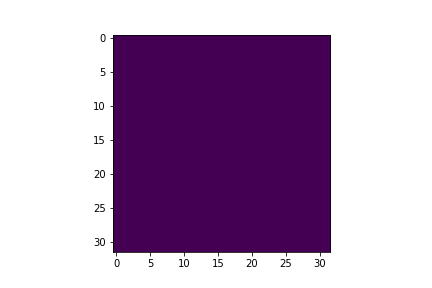

NameError: name 'animation' is not defined

In [7]:
%matplotlib notebook
fig, ax = plt.subplots()
imgs = ax.imshow(np.zeros((ds.Nx, ds.Ny)))     # A tuple unpacking to unpack the only plot
vmin, vmax = np.min(ds._data), np.max(ds._data)
imgs.set_clim(vmin=vmin, vmax=vmax)
#ax.set_xlim(0, 2*np.pi)
#ax.set_ylim(-1.1, 1.1)
def animate(frame_num):
    #print(frame_num)
    mid = ds._data.shape[0] // 2
    _d = ds._data[mid-20+frame_num, :, :]
    imgs.set_data(_d)
    vmin, vmax = np.min(_d), np.max(_d)
    imgs.set_clim(vmin=vmin, vmax=vmax)
    ax.set_title('frame %d'%frame_num)
    return imgs
anim = animation.FuncAnimation(fig, animate, frames=40, 
                               interval=10, repeat=True)
plt.show()
print(ds._data.shape)

In [ ]:
%matplotlib inline

interval = ZScaleInterval()
### can make a gif routine to slice through the cube!
print(ds._data.shape)
limits = interval.get_limits(ds._data[38,:,:])
print(limits)
plt.imshow(ds._data[38,:,:], origin = 'lower', cmap='gray',
           norm=ImageNormalize(ds._data[38,:,:], interval=ZScaleInterval()))
ax = plt.gca()
xmid = np.mean(ax.get_xlim())
ymid = np.mean(ax.get_ylim())
plt.axvline(xmid, color='cyan', ls='--')
plt.axhline(ymid, color='cyan', ls='--')

print(ax.get_xlim())

# Testing `LogLikelihood_Roman` Class

In [ ]:
print(test_Pars.meta)
fid_sampled_pars = [0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5]
like = LogLikelihood_Roman(test_Pars, fid_pars=fid_sampled_pars)

In [ ]:
%time print("log-posterior = {}".format(\
    like([0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5])\
            ))

# Try `yaml` parameter file

In [ ]:
pars_file = """

sampled_pars:
    g1:
        fid: 0.0
        min: -1.0
        max: 1.0
        order: 1
    g2:
        fid: 0.0
        min: -1.0
        max: 1.0
        order: 2
    theta_int:
        fid: 0.0
        min: -1.5708
        max:  1.5708
        order: 3
    sini:
        fid: 0.5
        min: -1.0
        max: 1.0
        order: 4
    v0:
        fid: 0.0
        mean: 0.0
        std:  20.0
        order: 5
    vcirc:
        fid: 200.0
        mean: 200.0
        std: 10.0
        order: 6
    rscale:
        fid: 0.5
        min: 0.0
        max: 2.0
        order: 7

# dimension parameters for model cube
# Note that the dimensions and scales in this parameter are irrelevant
# to the pixel scale and number of pixels in the observed image. The 
# model cube object is by design independent of the configurations of
# observations. A parametric surface brightness profile is drawn on 
# this meta-grid, then observed data will be interpolated from that. 

model_dimension:
    Nx: 36
    Ny: 36
    scale: 0.1 # arcsec
    lambda_range: [1310., 1315.]
    lambda_res: 0.1 # nm
    lambda_unit: nm

# intensity profile, or surface brightness model for the galaxy

intensity:
    type: inclined_exp
    hlr: 0.5 # arcsec

# kinematics model for the galaxy

velocity:
    model_name: default
    v_unit: km / s
    r_unit: arcsec

# SED model for the galaxy

sed:
    template: ../../data/Simulation/GSB2.spec
    wave_type: Ang
    flux_type: flambda
    z: 1.0
    wave_range: [500., 3000.] # nm
    # obs-frame continuum normalization (nm, erg/s/cm2/nm)
    obs_cont_norm: [400, 1.0e-20]
    # a dict of line names and obs-frame flux values (erg/s/cm2)
    lines:
        Halpha: 1.0e-15
        OII: [1.0e-15, 1.2e-15]
        OIII: [1.0e-15, 1.2e-15]
    # intrinsic linewidth in nm
    line_sigma_int:
        Halpha: 0.2
        OII: [0.2, 0.2]
        OIII: [0.2, 0.2]

# observation related parameters
# Note that from the same galaxy and shear model, we can derive 
# multiple types of data,
# e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
# Thus 'observations' is a list of dictionaries that specify 
# observation-wise parameters.
# TODO: maybe think about more flexible way to describe dispersion
observations:
    number_of_observations: 3
    obs_1:
        # Roman WFI/GRISM-slit observation, roll angle 1
        inst_name: Roman/WFI
        type: slit
        slit_width: 0.3
        slit_offset: 0.0
        bandpass: ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
        Nx: 32
        Ny: 32
        pixel_scale: 0.11 # arcsec
        R_spec: 9220.0 # at 1 micron
        # can be 'airy'/'moffat'/'kolmogorov'/'vonkarman'/'opticalpsf'
        psf_type: airy
        # pass the needed params to build PSF model here
        # in case of airy, we don't need any params
        psf_kwargs:
            fwhm: 0.13 # arcsec
        disp_ang: 0.0 # radian
        offset: -24210.28168 # pix
        diameter: 240 # cm
        exp_time: 300. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.78
            read_noise: 8.5
     
    obs_2: # Roman WFI/GRISM-slit observation, roll angle 2
        inst_name: Roman/WFI
        type: slit
        slit_width: 0.3
        slit_offset: 0.0
        bandpass: ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
        Nx: 32              # number of pixels
        Ny: 32
        pixel_scale: 0.11      # arcsec
        R_spec: 9220.0            # at 1 micron
        psf_type: airy
        psf_kwargs: 
            fwhm: 0.13     # arcsec
        disp_ang: 1.5708  # radian
        offset: -24210.28168 #pix
        diameter: 240 # cm
        exp_time: 300. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.78
            read_noise: 8.5

    obs_3: # Roman WFI/Photometry image observation, H band
        inst_name: Roman/WFI
        type: photometry
        bandpass: ../../data/Bandpass/Roman/WFI_F129.dat
        Nx: 32 # number of pixels
        Ny: 32 
        pixel_scale: 0.11 # arcsec
        psf_type: airy
        psf_kwargs:
            fwhm: 0.13 # arcsec
        diameter: 240 # cm
        exp_time: 300. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.78
            read_noise: 8.5
            apply_to_data: True


use_numba: False
"""
print(yaml.dump(yaml.load(pars_file)))

In [ ]:
pars_dict = yaml.load(pars_file, Loader=yaml.FullLoader)
for key, val in pars_dict['sampled_pars'].items():
    print(key, val)

In [ ]:
pars_from_yaml = Pars(yaml_file=pars_file)

In [ ]:
#like_from_yaml = LogLikelihood_Roman(pars_from_yaml, fid_pars=pars_from_yaml.sampled_fid)
logprob = LogPosterior_Roman(pars_from_yaml, 
        fid_pars=pars_from_yaml.sampled_fid)

In [ ]:
%time print(f'loglike at fid pars = {logprob(pars_from_yaml.sampled_fid)}')
%time print(f'loglike at others = {logprob([0.01, 0.01, 0.01, 0.5, 0.0, 200.0, 1.0])}')

In [18]:
test_string = """

a: false
b: true
c: none
"""
test = yaml.load(test_string)
print(type(test['b']))
print(test['b'])

<class 'bool'>
True


/var/folders/y_/b_rv6p295ld1zh697qttx_yr0000gn/T/ipykernel_24860/2473645518.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  test = yaml.load(test_string)


# Hubble Space Telescope

## Simulated G141 Observation

In [2]:
R = 107.53 
z = 0.9513
offset = -656.461*(1+z)*R/500
print(offset)

-275.48161224045805


In [ ]:
pars_g141 = """

sampled_pars:
    g1:
        fid: 0.0
        min: -1.0
        max: 1.0
        order: 1
    g2:
        fid: 0.0
        min: -1.0
        max: 1.0
        order: 2
    theta_int:
        fid: 0.0
        min: -1.5708
        max:  1.5708
        order: 3
    sini:
        fid: 0.5
        min: -1.0
        max: 1.0
        order: 4
    v0:
        fid: 0.0
        mean: 0.0
        std:  20.0
        clip_sigmas: 10.0
        order: 5
    vcirc:
        fid: 200.0
        mean: 200.0
        std: 10.0
        clip_sigmas: 10.0
        order: 6
    rscale:
        fid: 0.5
        min: 0.0
        max: 2.0
        order: 7

# dimension parameters for model cube
# Note that the dimensions and scales in this parameter are irrelevant
# to the pixel scale and number of pixels in the observed image. The 
# model cube object is by design independent of the configurations of
# observations. A parametric surface brightness profile is drawn on 
# this meta-grid, then observed data will be interpolated from that. 

model_dimension:
    Nx: 64
    Ny: 64
    scale: 0.1 # arcsec
    lambda_range: [1190., 1370.]
    lambda_res: 4 # nm
    lambda_unit: nm

# intensity profile, or surface brightness model for the galaxy

intensity:
    type: inclined_exp
    hlr: 0.5 # arcsec

# kinematics model for the galaxy

velocity:
    model_name: default
    v_unit: km / s
    r_unit: arcsec

# SED model for the galaxy

sed:
    template: ../../data/Simulation/GSB2.spec
    wave_type: Ang
    flux_type: flambda
    z: 0.9513
    wave_range: [500., 3000.] # nm
    # obs-frame continuum normalization (nm, erg/s/cm2/nm)
    obs_cont_norm: [614, 3.9e-17]
    # a dict of line names and obs-frame flux values (erg/s/cm2)
    lines:
        Halpha: 5.0e-16
        OII: [1.0e-15, 1.2e-15]
        OIII: [1.0e-15, 1.2e-15]
    # intrinsic linewidth in nm
    line_sigma_int:
        Halpha: 2
        OII: [0.2, 0.2]
        OIII: [0.2, 0.2]

# observation related parameters
# Note that from the same galaxy and shear model, we can derive 
# multiple types of data,
# e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
# Thus 'observations' is a list of dictionaries that specify 
# observation-wise parameters.
# TODO: maybe think about more flexible way to describe dispersion
# 4 exposures per pointing, 800s in direct imaging and 5000s in grism
observations:
    number_of_observations: 3
    obs_1:
        # HST WFC3/IR G141 observation, roll angle 1
        inst_name: HST/WFC3
        type: grism
        bandpass: ../../data/Bandpass/HST/WFC3_IR_G141_1st.dat
        Nx: 36
        Ny: 36
        pixel_scale: 0.13 # arcsec
        R_spec: 107.53 # at 1 micron
        # can be 'airy'/'moffat'/'kolmogorov'/'vonkarman'/'opticalpsf'
        psf_type: airy
        # pass the needed params to build PSF model here
        # in case of airy, we don't need any params
        psf_kwargs:
            fwhm: 0.13 # arcsec
        disp_ang: 0.0 # radian
        offset: -275.48161224045805 # pix
        diameter: 240 # cm
        exp_time: 5000. # seconds
        gain: 1. # electron per ADU
        noise:
            type: ccd
            sky_level: 0.75 # 1.5 electron per sec per pix
            read_noise: 40 # 20 electron per pix per readout, x2
            apply_to_data: False
     
    obs_2: # HST WFC3/IR G141 observation, roll angle 2
        inst_name: HST/WFC3
        type: grism
        bandpass: ../../data/Bandpass/HST/WFC3_IR_G141_1st.dat
        Nx: 36              # number of pixels
        Ny: 36
        pixel_scale: 0.13      # arcsec
        R_spec:  107.53          # at 1 micron
        psf_type: airy
        psf_kwargs: 
            fwhm: 0.13     # arcsec
        disp_ang: 1.5708  # radian
        offset: -275.48161224045805 #pix
        diameter: 240 # cm
        exp_time: 5000. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.75
            read_noise: 40
            apply_to_data: False

    obs_3: # HST WFC3/IR image observation, F125W
        inst_name: HST/WFC3
        type: photometry
        bandpass: ../../data/Bandpass/HST/WFC3_IR_F125W.dat
        Nx: 36 # number of pixels
        Ny: 36 
        pixel_scale: 0.13 # arcsec
        psf_type: airy
        psf_kwargs:
            fwhm: 0.13 # arcsec
        diameter: 240 # cm
        exp_time: 800. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.75
            read_noise: 40
            apply_to_data: False


use_numba: False
"""
pars_from_yaml = Pars(yaml_file=pars_g141)

#like_from_yaml = LogLikelihood_Roman(pars_from_yaml, fid_pars=pars_from_yaml.sampled_fid)
logprob = LogPosterior_Roman(pars_from_yaml, 
        fid_pars=pars_from_yaml.sampled_fid)
data, covs = logprob.log_likelihood.dsim.evaluateSimulatedData(pars_from_yaml.sampled_fid, 
                                                               force_noise_free = False)

  points: [16958.11038606]
  lookup_table: [-4.43552851e-07] [synphot.models]


F140W band magnitude = 21.39 mag(AB)+0.08 mag-0.08 mag; should be 21.38


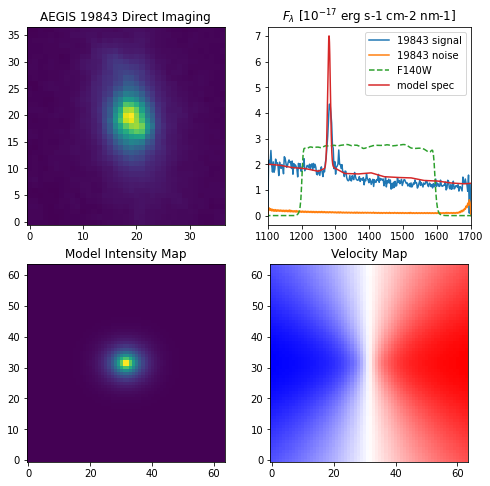

In [117]:
### Check model & compare with an example source
fig, axes = plt.subplots(2,2, figsize=(8,8))

### example source: AEGIS 19843
aegis_dir = "/Users/jiachuanxu/Workspace/HST/HST_GRISM_ARCHIVAL_DATA/3D_HST/AEGIS/aegis-01"
AEGIS_19843_2d = fits.open(aegis_dir+"/2D/FITS/aegis-01-G141_19843.2D.fits")
AEGIS_19843_1d = fits.open(aegis_dir+"/1D/FITS/aegis-01-G141_19843.1D.fits")
#wave = np.array([_d[0] for _d in AEGIS_19843_1d[1].data]) * u.Angstrom
wave = AEGIS_19843_1d[1].data['WAVE'] * u.Angstrom
#flam = np.array([_d[1] for _d in AEGIS_19843_1d[1].data]) * u.Unit('s-1')
flam = AEGIS_19843_1d[1].data['FLUX'] * u.Unit('s-1')
flam[np.where(wave<1100*u.nm)] = 0 / u.s
flam[np.where(wave>1700*u.nm)] = 0 / u.s
#errs = np.array([_d[2] for _d in AEGIS_19843_1d[1].data]) * u.Unit('s-1')
errs = AEGIS_19843_1d[1].data['ERROR'] * u.Unit('s-1')
errs[np.where(wave<1100*u.nm)] = 0 / u.s
errs[np.where(wave>1700*u.nm)] = 0 / u.s
#sens = AEGIS_19843_1d[1].data['SENSITIVITY'] * u.Unit('erg-1 cm2') * 1e17 
sens = AEGIS_19843_1d[1].data['SENSITIVITY'] * u.Unit('erg-1 cm2 Angstrom') * 1e17
dlamdpix = 46.5*u.Angstrom/2.

axes[0,0].imshow(AEGIS_19843_2d[1].data, origin='lower')
axes[0,0].set_title('AEGIS 19843 Direct Imaging')
axes[0,1].plot(wave.to('nm'), 
               #(flam/sens/dlamdpix).to('erg s-1 cm-2 nm-1') * 1e18, 
               (flam/sens).to('erg s-1 cm-2 nm-1') * 1e17,
               label='19843 signal')
axes[0,1].plot(wave.to('nm'), 
               #(errs/sens/dlamdpix).to('erg s-1 cm-2 nm-1') * 1e18,
               (errs/sens).to('erg s-1 cm-2 nm-1') * 1e17,
               label='19843 noise')
axes[0,1].set(#ylim = (0, 7),
              xlim=(1100,1700), 
              #ylabel = r'$F_\lambda$ [$1e-18$ erg s-1 cm-2 nm-1]', 
              #xlabel='wavelength [nm]'
             )
axes[0,1].set_title(r'$F_\lambda$ [$10^{-17}$ erg s-1 cm-2 nm-1]')
# check the F140W magnitude of the spectrum (m140 = 21.38)
spec1d = Spectrum1D(
    spectral_axis=wave.to('nm'), 
    flux=(flam/sens).to('erg s-1 cm-2 nm-1')
    )
spec1dp = Spectrum1D(
    spectral_axis=wave.to('nm'), 
    flux=((flam+errs)/sens).to('erg s-1 cm-2 nm-1')
    )
spec1dm = Spectrum1D(
    spectral_axis=wave.to('nm'), 
    flux=((flam-errs)/sens).to('erg s-1 cm-2 nm-1')
    )
#sp = SourceSpectrum.from_spectrum1d(spec1d)
bp = stsyn.band('cos,wfc3,ir,f140w')
obs = Observation(spec1d, bp, binset=bp.binset)
obs_p = Observation(spec1dp, bp, binset=bp.binset)
obs_m = Observation(spec1dm, bp, binset=bp.binset)
mag_f140w = obs.effstim(u.ABmag)
mag_f140w_p = obs_p.effstim(u.ABmag)
mag_f140w_m = obs_m.effstim(u.ABmag)
print('F140W band magnitude = {:.2f}+{:.2f}-{:.2f}; should be 21.38'.format(
    mag_f140w, mag_f140w_m-mag_f140w,mag_f140w-mag_f140w_p))
axes[0,1].plot(wave.to('nm'), bp(wave.to('nm'))*5, ls='--' ,label='F140W')
### model
ds = logprob.log_likelihood.dsim

axes[1,0].imshow(ds.imap_img, origin='lower')
axes[1,0].set_title('Model Intensity Map')

### galsim.SED object return interpolated spectrum in units of photons/s/cm2/nm
#_x = wave.to('nm')
_x = np.linspace(1100,1700,60000)*u.nm
model_spec =  ds.sed.spectrum(_x.value)*u.Unit('s-1 cm-2 nm-1')*(const.h*const.c/_x)
axes[0,1].plot(_x, model_spec.to('erg s-1 cm-2 nm-1') * 1e17, label='model spec')

axes[0,1].legend(loc='upper right')

axes[1,1].imshow(ds.vmap_img, origin='lower', cmap='bwr')
axes[1,1].set_title('Velocity Map')

plt.show()

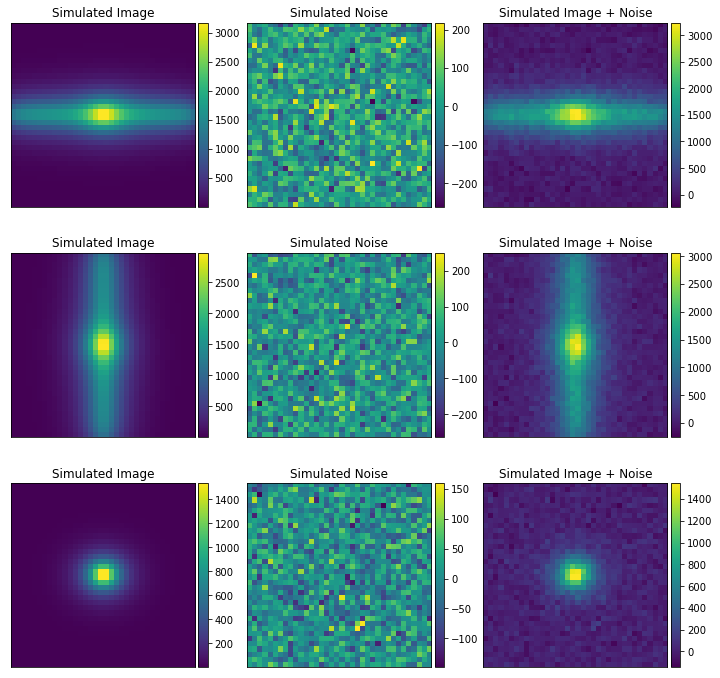

In [111]:
fig, axes = plt.subplots(3,3,figsize=(12,12))

### Grism disp. along x

ax = axes[0,0]
img = data[0]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Image')

ax = axes[0,1]
img = covs[0]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Noise')

ax = axes[0,2]
img = covs[0]+data[0]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Image + Noise')

### Grism disp. along y

ax = axes[1,0]
img = data[1]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Image')

ax = axes[1,1]
img = covs[1]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Noise')

ax = axes[1,2]
img = covs[1]+data[1]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Image + Noise')

### F125W image

ax = axes[2,0]
img = data[2]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Image')

ax = axes[2,1]
img = covs[2]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Noise')

ax = axes[2,2]
img = covs[2]+data[2]
cb = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
ax.set(xticks=[], yticks=[], title='Simulated Image + Noise')

plt.show()

In [104]:
print(logprob(pars_from_yaml.sampled_fid))

(-11.053515379478826, (-11.053515379478826, 0.0))


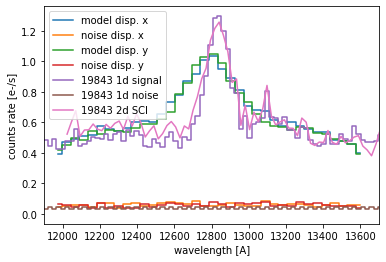

In [122]:
offset = -275.48161224045805
wavelength = (np.arange(-18,18,1)-offset) * 46.5*u.Angstrom
hw = 8
plt.plot(wavelength, np.sum((data[0]+covs[0])[18-hw:18+hw,:]/5000/4, axis=0), 
         drawstyle='steps-mid', label='model disp. x')
plt.plot(wavelength, np.sqrt( np.sum( (covs[0][18-hw:18+hw,:]/5000)**2, axis=0) ), 
         drawstyle='steps-mid', label='noise disp. x')

plt.plot(wavelength, np.sum((data[1]+covs[1])[:,18-hw:18+hw]/5000/4, axis=1), 
         drawstyle='steps-mid', label='model disp. y')
plt.plot(wavelength, np.sqrt( np.sum( (covs[1][:,18-hw:18+hw]/5000)**2, axis=1) ), 
         drawstyle='steps-mid', label='noise disp. y')

wave_bin = [wave[i*2].to('Angstrom').value for i in range(len(wave)//2)]
flam_bin = [(flam[i*2]+flam[i*2+1]).value for i in range(len(flam)//2)]
errs_bin = [np.sqrt(errs[i*2] **2 + errs[i*2+1]**2).value for i in range(len(errs)//2)]
#print(wave_bin, flam_bin, errs_bin)
#plt.plot(wave_bin, flam_bin, label='19843 signal', drawstyle='steps-mid')
#plt.plot(wave_bin, errs_bin, label='19843 signal')
plt.plot(wave.to('Angstrom'), flam, label='19843 1d signal', drawstyle='steps-mid')
plt.plot(wave.to('Angstrom'), errs, label='19843 1d noise', drawstyle='steps-mid')

### 2d spectrum
index = np.where(np.logical_and(AEGIS_19843_2d[9].data > 12000,
                       AEGIS_19843_2d[9].data < 14000))[0]
plt.plot(AEGIS_19843_2d[9].data[index], np.sum(AEGIS_19843_2d[5].data[:,index], axis=0),
        label='19843 2d SCI')

plt.xlim(11900,13700)
plt.xlabel('wavelength [A]')
plt.ylabel('counts rate [e-/s]')
plt.legend()

Residual: mean = 0.0012; std = 0.0086; 1-sigma = 0.0081


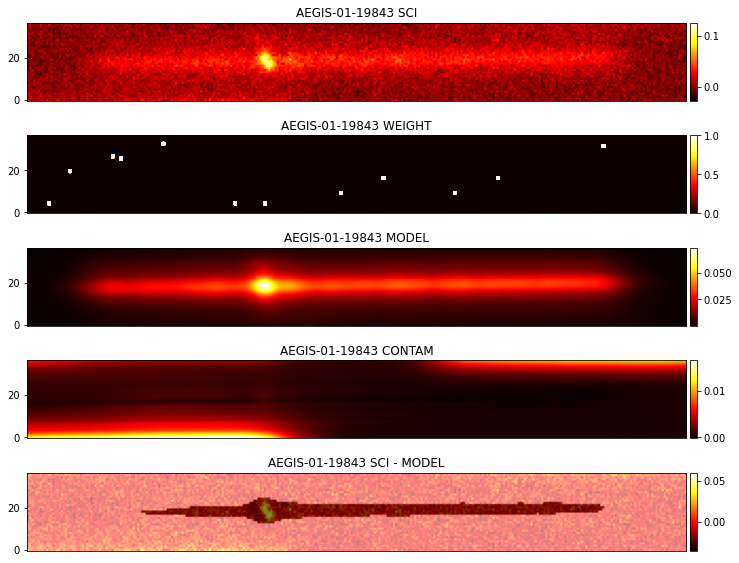

In [63]:
fig, axes = plt.subplots(5,1,figsize=(12,10))

cb1 = axes[0].imshow(AEGIS_19843_2d[5].data, 
                origin='lower', cmap='hot',
               #extent = [AEGIS_01_19843[9].data[0], AEGIS_01_19843[9].data[-1], 0, 37]
               )
axes[0].set_xticks([])
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(cb1, cax=cax, orientation='vertical')
axes[0].set_title('AEGIS-01-19843 SCI')

cb2 = axes[1].imshow(AEGIS_19843_2d[6].data, 
                origin='lower', cmap='hot',
                     vmin=0,vmax=1,
               #extent = [AEGIS_01_19843[9].data[0], AEGIS_01_19843[9].data[-1], 0, 37]
               )
axes[1].set_xticks([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(cb2, cax=cax, orientation='vertical')
axes[1].set_title('AEGIS-01-19843 WEIGHT')

cb3 = axes[2].imshow(AEGIS_19843_2d[7].data, 
                origin='lower', cmap='hot',
               #extent = [AEGIS_01_19843[9].data[0], AEGIS_01_19843[9].data[-1], 0, 37]
               )
axes[2].set_xticks([])
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(cb3, cax=cax, orientation='vertical')
axes[2].set_title('AEGIS-01-19843 MODEL')

cb4 = axes[3].imshow(AEGIS_19843_2d[8].data, 
                origin='lower', cmap='hot',
               #extent = [AEGIS_01_19843[9].data[0], AEGIS_01_19843[9].data[-1], 0, 37]
               )
axes[3].set_xticks([])
divider = make_axes_locatable(axes[3])
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(cb4, cax=cax, orientation='vertical')
axes[3].set_title('AEGIS-01-19843 CONTAM')

residuals = AEGIS_19843_2d[5].data - AEGIS_19843_2d[7].data
res_mean, res_std, res_1sigma = np.mean(residuals), np.std(residuals), \
      (np.percentile(residuals, 84)-np.percentile(residuals, 16))/2.
print('Residual: mean = {:.4f}; std = {:.4f}; 1-sigma = {:.4f}'.format(
        res_mean, res_std, res_1sigma
        ))
mask = np.where(AEGIS_19843_2d[7].data > 3 * res_std + res_mean,
                np.ones(AEGIS_19843_2d[7].data.shape),
                np.zeros(AEGIS_19843_2d[7].data.shape))
cb5 = axes[4].imshow(residuals, 
                origin='lower', cmap='hot',
               #extent = [AEGIS_01_19843[9].data[0], AEGIS_01_19843[9].data[-1], 0, 37]
               )
axes[4].imshow(mask, cmap='binary', alpha=0.5, origin='lower')
axes[4].set_xticks([])
divider = make_axes_locatable(axes[4])
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(cb5, cax=cax, orientation='vertical')
axes[4].set_title('AEGIS-01-19843 SCI - MODEL')

plt.show()

[23.32538065 23.32703901 23.32869737 23.33035573 23.33201408 23.33367244
 23.3353308  23.33698916 23.33864752 23.34030588 23.34196424 23.3436226
 23.34528096 23.34693932 23.34859768 23.35025604 23.3519144  23.35357276
 23.35523112 23.35688948 23.35854783 23.36020619 23.36186455 23.36352291
 23.36518127 23.36683963 23.36849799 23.37015635 23.37181471 23.37347307
 23.37513143 23.37678979 23.37844815 23.38010651 23.38176487 23.38342323
 23.38508158 23.38673994 23.3883983  23.39005666 23.39171502 23.39337338
 23.39503174 23.3966901  23.39834846 23.40000682 23.40166518 23.40332354
 23.4049819  23.40664026 23.40829862 23.40995698 23.41161533 23.41327369
 23.41493205 23.41659041 23.41824877 23.41990713 23.42156549 23.42322385
 23.42488221 23.42654057 23.42819893 23.42985729 23.43151565 23.43317401
 23.43483237 23.43649073 23.43814908 23.43980744 23.4414658  23.44312416
 23.44478252 23.44644088 23.44809924 23.4497576  23.45141596 23.45307432
 23.45473268 23.45639104 23.4580494  23.45970776 23.

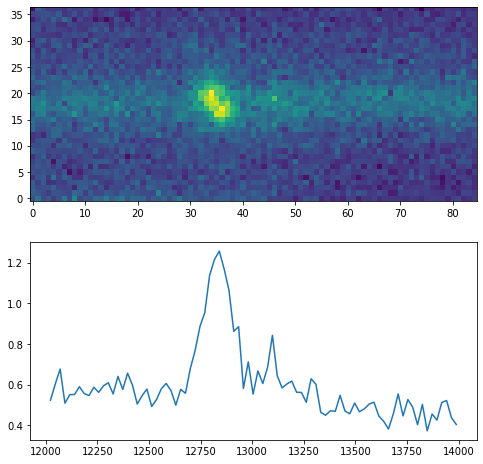

In [64]:
index = np.where(np.logical_and(AEGIS_19843_2d[9].data > 12000,
                       AEGIS_19843_2d[9].data < 14000))[0]
print(AEGIS_19843_2d[9].data[index]-AEGIS_19843_2d[9].data[index-1])
fig, axes = plt.subplots(2,1, figsize=(8,8))

axes[0].imshow(AEGIS_19843_2d[5].data[:,index], origin='lower')
axes[1].plot(AEGIS_19843_2d[9].data[index], np.sum(AEGIS_19843_2d[5].data[:,index], axis=0))

In [62]:
lambda_cen = ds.lambda_cen
#vmap_img = ds.vmap_img
vmap_img = np.zeros(ds.vmap_img.shape)

w_mesh = np.outer(lambda_cen, 1./(1.+vmap_img))
w_mesh = w_mesh.reshape(lambda_cen.shape+vmap_img.shape)
# photons/s/cm2 in the 3D grid
dc_array = ds.sed.spectrum(w_mesh.flatten()) * ds.dlam
dc_array = dc_array.reshape(w_mesh.shape) * \
                ds.imap_img[np.newaxis, :, :] /\
                (1+vmap_img[np.newaxis, :, :]) 

In [63]:
trace = np.sum(dc_array, axis=(1,2))

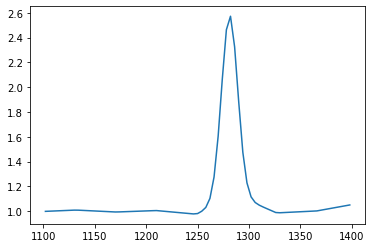

In [64]:
plt.plot(lambda_cen, trace*np.pi*(1.2*100)**2*0.5)

In [65]:
AEGIS_19843_1d[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =                  312 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
ATRACE  =    13.63783300743683 / Factor to scale trace to total flux            
RA      =          214.8994043 / Target R.A.                                    
DEC     =           52.8603738 / Target Dec.                                    
X_PIX   =        1160.41459855 / X pixel in interlaced image                    
Y_PIX   =        1403.354373

In [14]:
sp = SourceSpectrum.from_vega()
bp = stsyn.band('wfc3,ir,f140w')
obs_test = Observation(sp, bp, binset=bp.binset)
obs_test.effstim(synphot.units.VEGAMAG, vegaspec=sp)

<Quantity 0. VEGAMAG>

In [107]:
print(AEGIS_19843_1d[1].data['SENSITIVITY']) #erg/cm3/s

[0.01596722 0.01840516 0.02144083 0.02502366 0.02876097 0.0324814
 0.03609557 0.03952569 0.04334873 0.04780089 0.05419926 0.06317426
 0.07469165 0.08890823 0.10454169 0.12106558 0.13786547 0.15452105
 0.17218489 0.19130638 0.21631224 0.24942183 0.29454097 0.35415242
 0.42635421 0.51094257 0.60074487 0.69224696 0.77981437 0.85971195
 0.93439518 1.00394546 1.07560467 1.15285403 1.23656106 1.32815471
 1.42116364 1.51287471 1.59613274 1.66670287 1.72495601 1.76980455
 1.80520232 1.83270613 1.85561743 1.87595909 1.89497471 1.91386202
 1.93330721 1.95396268 1.97431598 1.99387365 2.01178542 2.02751937
 2.04029283 2.04963564 2.05731588 2.06398289 2.07192687 2.08230077
 2.09590563 2.11337938 2.13391215 2.15734623 2.18279951 2.2098616
 2.23704462 2.26367494 2.28951091 2.31426836 2.33709307 2.35762868
 2.37671796 2.39457169 2.41197776 2.42926144 2.44708374 2.46570735
 2.48421352 2.50236746 2.51925885 2.53460053 2.54931669 2.56362846
 2.57881273 2.59521891 2.61206967 2.62921389 2.64543633 2.660447

In [116]:
np.arcsin(0.5)

0.5235987755982988